In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_lfw_people

# 1.1)

## Recap: Laden  der Bilder

In [2]:
faces  = fetch_lfw_people(min_faces_per_person=60)
faces.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [3]:
len(faces["target"]), faces["data"].shape

(1348, (1348, 2914))

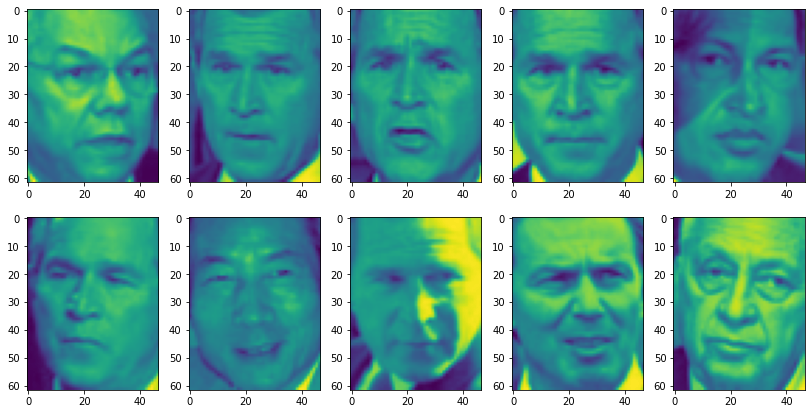

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=[14, 7])
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(faces["images"][i * 5 + j])
plt.show()

In [5]:
H = faces["images"].shape[1]
W = faces["images"].shape[2]
H, W

(62, 47)

In [6]:
def mirror_faces_data(faces, index):
    face_copy = faces[index].copy()
    face_copy = face_copy.reshape(H, W)
    face_reshaped = face_copy[..., ::-1, :]
    face_reshaped = face_reshaped.reshape(H * W)
    return face_reshaped

In [7]:
faces["images"].shape

(1348, 62, 47)

In [8]:
modified_face = mirror_faces_data(faces["data"], 3)
faces["data"][3].shape, modified_face.shape

((2914,), (2914,))

In [9]:
np.array_equal(faces["data"][3], modified_face)

False

# 1.2)

In [10]:
from sklearn.decomposition import PCA

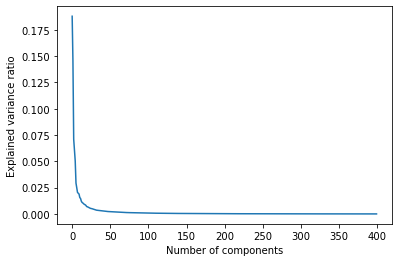

In [11]:
pca = PCA(n_components=400).fit(faces["data"])
unmodified_transformation = pca.transform(faces["data"])
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.show()

In [12]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [13]:
def calc_reconstruction_error(pca, pca_data, target_data):
    data_retrf = pca.inverse_transform(pca_data)
    errors = [rmse(data_retrf[i], target_data[i]) for i in range(len(data_retrf))]
    return errors

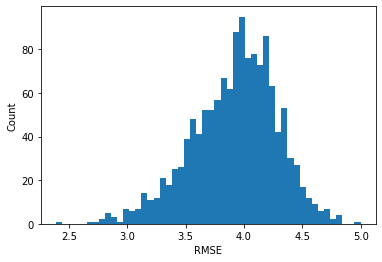

In [14]:
recon_errors = calc_reconstruction_error(pca, unmodified_transformation, faces["data"])
plt.hist(recon_errors, bins=50)
plt.xlabel("RMSE")
plt.ylabel("Count")
plt.show()

# 1.3)

In [15]:
def create_some_outliers(indices):
    return np.array([mirror_faces_data(faces["data"], index) for index in indices])

In [16]:
indices = np.arange(0, len(faces["data"]) / 2).astype(int)
outliers = create_some_outliers(indices)
outliers.shape

(674, 2914)

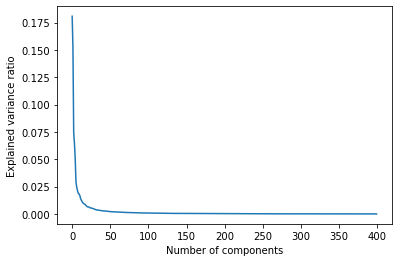

In [17]:
outlier_pca = PCA(n_components=400).fit(outliers)
data_transf = outlier_pca.transform(outliers)
plt.plot(outlier_pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.show()

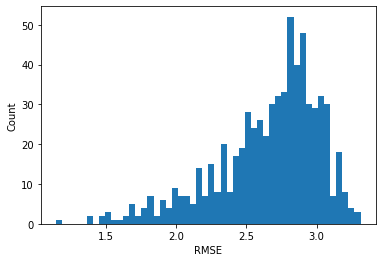

In [18]:
outlier_errors = calc_reconstruction_error(outlier_pca, data_transf, outliers)
plt.hist(outlier_errors, bins=50)
plt.xlabel("RMSE")
plt.ylabel("Count")
plt.show()

# 2.)

In [19]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [20]:
def create_kde_data(n_components):
    # Create PCA data
    compressed_pca = PCA(n_components).fit(faces["data"])
    compressed_data = compressed_pca.transform(faces["data"])
    
    # CV
    param_grid = {"bandwidth": [0.1, 0.2, 0.3, 0.4, 0.5], "kernel": ["gaussian", "exponential"]}
    grid = GridSearchCV(KernelDensity(), param_grid, cv=3)
    grid.fit(compressed_data.reshape(-1, 1))
    
    # Hier eine Abweichung vom best estimator, da Kernel exponential wohl "not implemented" ist.
    # Vllt ist aber auch die Anwendung der CV falsch.
    kde = KernelDensity(bandwidth=grid.best_estimator_.bandwidth, kernel='gaussian')
    kde.fit(compressed_data.reshape(-1, 1))
    
    # Create kde samples
    recons = np.array([kde.sample(n_samples=n_components) for i in range(100)])
    recons = recons.reshape(100, n_components)
    
    # Inverse tranfsormation
    retransformed = np.array([compressed_pca.inverse_transform(recon) for recon in recons])
    retransformed_reshaped = retransformed.reshape(100, H, W)
    return retransformed_reshaped

## Num Components = 10

In [21]:
samples = create_kde_data(10)
samples.shape

(100, 62, 47)

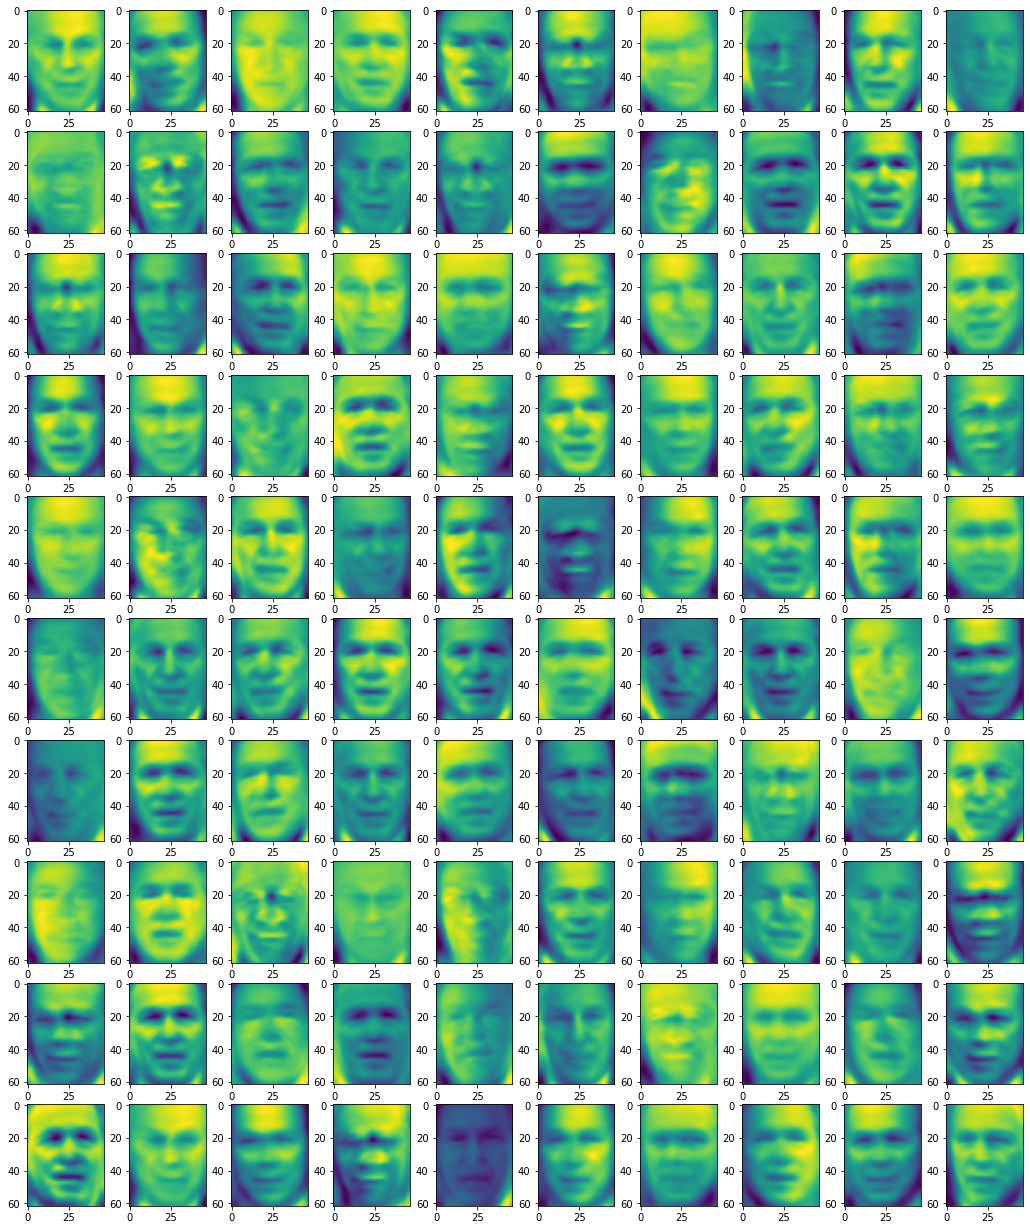

In [22]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=[18, 22])
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(samples[i * 10 + j])
plt.show()

# Num components = 50 (dauert sehr lange)

In [24]:
other_samples = create_kde_data(50)
other_samples.shape

(100, 62, 47)

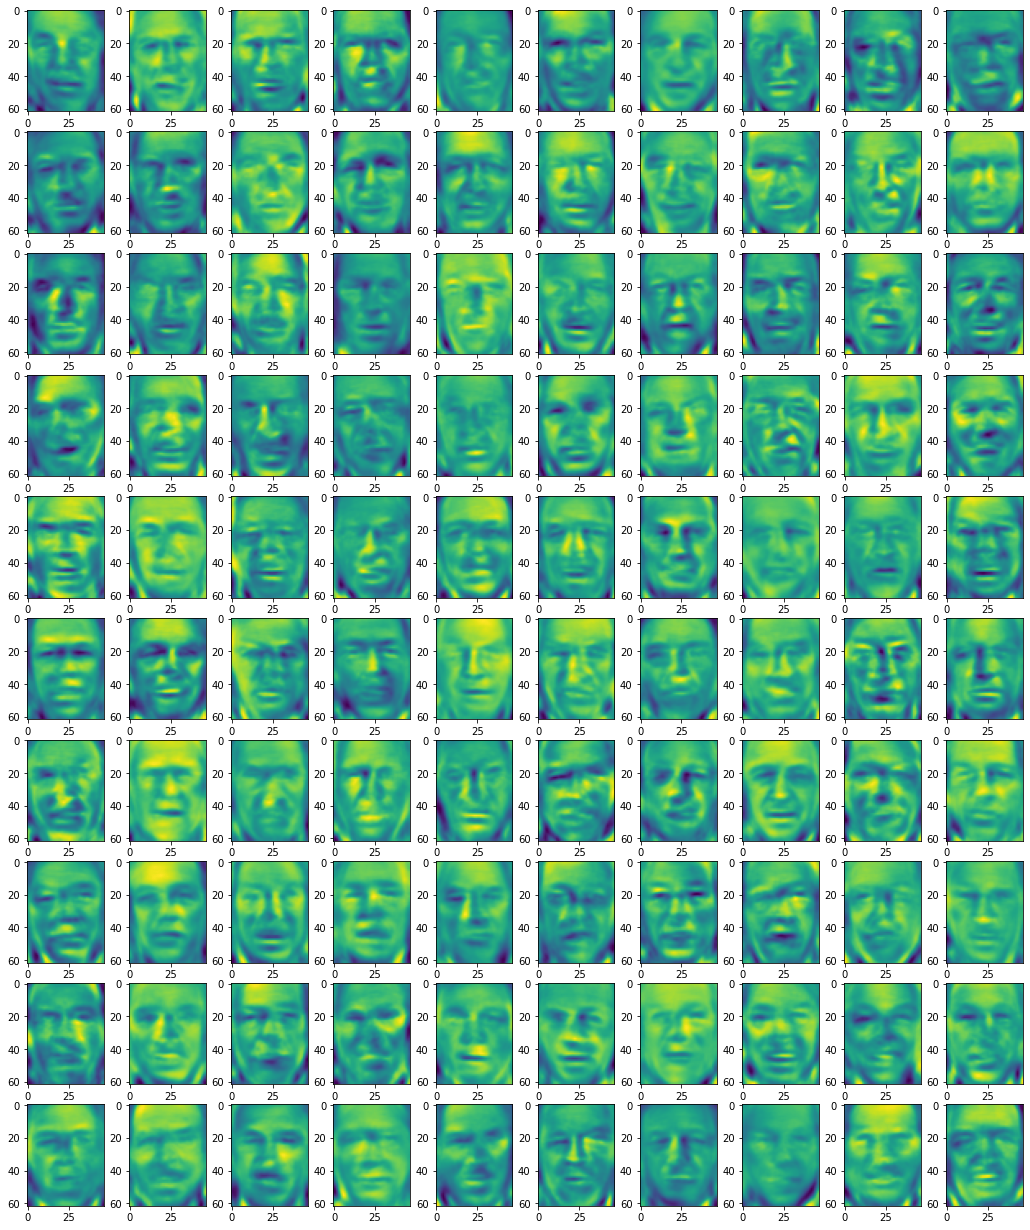

In [25]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=[18, 22])
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(other_samples[i * 10 + j])
plt.show()